<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/ViT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [3]:
import torch
import random
import timeit
import math
import numpy
import numpy as np
from torch import optim
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
#################
# CONFIGURATION #
#################

In [5]:
@dataclass
class vit_config:
    num_channels: int = 3
    batch_size:int = 16
    image_size: int = 224
    patch_size: int = 16
    num_heads:int = 8
    dropout: float = 0.0
    layer_norm_eps: float = 1e-6
    num_encoder_layers: int = 12
    random_seed: int = 42
    epochs: int = 30
    num_classes: int = 10
    learning_rate: float = 1e-5
    adam_weight_decay: int = 0
    adam_betas: tuple = (0.9, 0.999)
    embd_dim: int = (patch_size ** 2) * num_channels           # 768
    num_patches: int = (image_size // patch_size) ** 2         # 196
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
config = vit_config

random.seed(config.random_seed)
numpy.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [7]:
##################
# MODEL BUILDING #
##################

In [8]:
class VisionEmbedding(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()

        self.config  = config
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(
                in_channels=config.num_channels,
                out_channels=config.embd_dim,
                kernel_size=config.patch_size,
                stride=config.patch_size,
                padding="valid"
            ),
            nn.Flatten(start_dim=2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, config.embd_dim)), requires_grad=True)
        self.pos_embeddings = nn.Parameter(torch.randn(size=(1, config.num_patches + 1, config.embd_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=config.dropout)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        patch_embd = self.patch_embedding(x).transpose(2,1)
        patch_embd = torch.cat([cls_token, patch_embd], dim=1)
        embd = self.pos_embeddings + patch_embd
        embd = self.dropout(embd)
        return embd

In [9]:
class VisionAttention(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()

        self.embd_dim = config.embd_dim
        self.num_heads = config.num_heads
        self.dropout = config.dropout

        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.k_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.v_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape

        query = self.q_proj(x)
        key = self.k_proj(x)
        value = self.v_proj(x)

        query = query.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        key = key.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)
        value = value.view(B, T, self.num_heads, C//self.num_heads).transpose(1,2)

        attn_score = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))
        attn_score = F.softmax(attn_score, dim=-1).to(query.dtype)

        attn_out = (attn_score @ value).transpose(1,2)
        attn_out = attn_out.reshape(B, T, C).contiguous()
        attn_out = self.out_proj(attn_out)
        attn_out = F.dropout(attn_out, p=self.dropout, training=self.training)

        return attn_out

In [10]:
class VisionMLP(nn.Module):
    def __init__(self, config:vit_config):
        super().__init__()

        self.layer1 = nn.Linear(config.embd_dim, 3 * config.embd_dim)
        self.layer2 = nn.Linear(3 * config.embd_dim, config.embd_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = nn.functional.gelu(x, approximate="tanh")
        x = self.layer2(x)
        return x

In [11]:
class VisionEncoderLayer(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()

        self.embd_dim = config.embd_dim
        self.attn = VisionAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        self.mlp = VisionMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x

In [12]:
class VisionEncoder(nn.Module):
    def __init__(self, config: vit_config):
        super().__init__()
        self.layers = nn.ModuleList([VisionEncoderLayer(config) for _ in range(config.num_encoder_layers)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
class VisionTransformer(nn.Module):
    def __init__(self, config= vit_config):
        super().__init__()

        self.embedding = VisionEmbedding(config)
        self.encoder = VisionEncoder(config)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(config.embd_dim, eps=config.layer_norm_eps),
            nn.Linear(config.embd_dim, config.num_classes)
        )

    def forward(self, x:torch.Tensor ) -> torch.Tensor:
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [14]:
vit = VisionTransformer(vit_config)
summary(model=vit,
        input_size=(16, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)         [16, 3, 224, 224]    [16, 10]             --                   True
├─VisionEmbedding (embedding)                 [16, 3, 224, 224]    [16, 197, 768]       152,064              True
│    └─Sequential (patch_embedding)           [16, 3, 224, 224]    [16, 768, 196]       --                   True
│    │    └─Conv2d (0)                        [16, 3, 224, 224]    [16, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                       [16, 768, 14, 14]    [16, 768, 196]       --                   --
│    └─Dropout (dropout)                      [16, 197, 768]       [16, 197, 768]       --                   --
├─VisionEncoder (encoder)                     [16, 197, 768]       [16, 197, 768]       --                   True
│    └─ModuleList (layers)                    --                   --                  

In [15]:
####################
# DATA ACQUISITION #
####################

In [16]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2025-12-06 15:37:22--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-12-06 15:37:22--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  27.3MB/s    in 13s     

2025-12-06 15:37:36 (25.1 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [17]:
!tar -xzf 102flowers.tgz

In [18]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2025-12-06 15:37:57--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2025-12-06 15:37:58--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2025-12-06 15:37:59 (142 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [19]:
####################
# DATA PREPARATION #
####################

In [20]:
import os
import shutil
import numpy as np
import scipy.io as sio

# Paths
img_dir = "jpg"  # folder containing all images
split_dir = "flowers-data"  # where train/val/test folders will go
mat_file = "imagelabels.mat"

# Load labels
mat = sio.loadmat(mat_file)
labels = mat['labels'][0]  # shape: (1360,)
num_classes = 102

# Create folder structure
for split in ["train", "valid", "test"]:
    for cls in range(1, num_classes+1):
        os.makedirs(os.path.join(split_dir, split, str(cls)), exist_ok=True)

# Seed for reproducibility
np.random.seed(42)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop over classes to split images
for cls in range(1, num_classes+1):
    cls_indices = np.where(labels == cls)[0]  # indices of this class
    np.random.shuffle(cls_indices)

    n = len(cls_indices)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_idx = cls_indices[:n_train]
    val_idx = cls_indices[n_train:n_train+n_val]
    test_idx = cls_indices[n_train+n_val:]

    for idx in train_idx:
        src = os.path.join(img_dir, f"image_{idx+1:05d}.jpg")
        dst = os.path.join(split_dir, "train", str(cls), f"image_{idx+1:04d}.jpg")
        shutil.copy(src, dst)

    for idx in val_idx:
        src = os.path.join(img_dir, f"image_{idx+1:05d}.jpg")
        dst = os.path.join(split_dir, "valid", str(cls), f"image_{idx+1:04d}.jpg")
        shutil.copy(src, dst)

    for idx in test_idx:
        src = os.path.join(img_dir, f"image_{idx+1:05d}.jpg")
        dst = os.path.join(split_dir, "test", str(cls), f"image_{idx+1:04d}.jpg")
        shutil.copy(src, dst)


In [21]:
!rm -r /content/flowers-data/train/{11..102}
!rm -r /content/flowers-data/valid/{11..102}
!rm -r /content/flowers-data/test/{11..102}

In [22]:
######################
# DATA PREPROCESSING #
######################

In [23]:
train_data_dir = "/content/flowers-data/train"
val_data_dir = "/content/flowers-data/valid"
test_data_dir = "/content/flowers-data/test"

In [24]:
class TrainDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomResizedCrop(config.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "index": index
        }

In [25]:
class ValidationDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "index": index
        }

In [26]:
class TestDataset(Dataset):
    def __init__(self, root_dir, config:vit_config):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.image_size = config.image_size
        self.classes = self.dataset.classes

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_path, label = self.dataset.samples[index]

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "label" : label,
            "index": index
        }

In [27]:
train_dataset = TrainDataset(train_data_dir, vit_config)
val_dataset = ValidationDataset(val_data_dir, vit_config)
test_dataset = TestDataset(test_data_dir, vit_config)

In [28]:
len(train_dataset), len(val_dataset), len(test_dataset)
classes = train_dataset.classes

363
------------------------------
74
------------------------------
85
------------------------------


<Figure size 640x480 with 0 Axes>

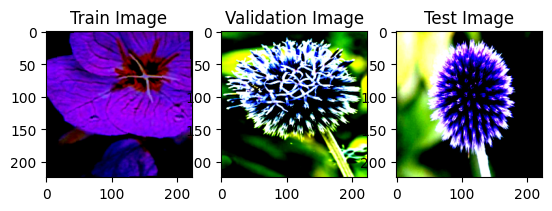

In [29]:
plt.figure()
f, axarr = plt.subplots(1, 3)
print(len(train_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img = train_dataset[0]["image"].squeeze().permute(1, 2, 0)
axarr[0].imshow(img)
axarr[0].set_title("Train Image")
print("-" * 30)


print(len(val_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img1 = val_dataset[10]["image"].squeeze().permute(1, 2, 0)
axarr[1].imshow(img1)
axarr[1].set_title("Validation Image")
print("-" * 30)


print(len(test_dataset))

# Transpose the image from (3, 224, 224) to (224, 224, 3)
img2 = test_dataset[6]["image"].squeeze().permute(1, 2, 0)
axarr[2].imshow(img2)
axarr[2].set_title("Test Image")
print("-" * 30)

In [30]:
train_dataloader = DataLoader(
                        dataset=train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True
                    )

val_dataloader = DataLoader(
                        dataset=val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False
                    )

test_dataloader = DataLoader(
                        dataset=test_dataset,
                        batch_size=config.batch_size,
                        shuffle=False
                    )

In [31]:
config = vit_config
model = VisionTransformer(config)
model.to(config.device)

VisionTransformer(
  (embedding): VisionEmbedding(
    (patch_embedding): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): VisionEncoder(
    (layers): ModuleList(
      (0-11): 12 x VisionEncoderLayer(
        (attn): VisionAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): VisionMLP(
          (layer1): Linear(in_features=768, out_features=2304, bias=True)
          (layer2): Linear(in_features=2304, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps

In [52]:
##################
# MODEL TRAINING #
##################

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=config.adam_betas, lr = config.learning_rate, weight_decay=config.adam_weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

start = timeit.default_timer()

for epoch in range(config.epochs):

    # training
    model.train()

    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, image in enumerate(tqdm(train_dataloader, position=0, desc="training")):
        img = image["image"].float().to(config.device)
        label = image["label"].type(torch.uint8).to(config.device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss/ (idx+1)

    #validation
    model.eval()
    valid_labels = []
    valid_preds = []
    valid_running_loss = 0
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_dataloader, position=0, desc="validation")):
            img = image["image"].float().to(config.device)
            label = image["label"].type(torch.uint8).to(config.device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            valid_labels.extend(label.cpu().detach())
            valid_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            valid_running_loss += loss.item()

    val_loss = valid_running_loss/(idx + 1)

    print("-"*30)

    scheduler.step()
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    print("-"*30)
    print(f"Train loss epoch {epoch + 1}: {train_loss:.4f}")
    print(f"Valid loss epoch {epoch + 1}: {val_loss:.4f}")
    print(f"Train accuracy epoch {epoch+1} : {sum(1 for x, y in zip(train_labels, train_preds) if x==y)/len(train_labels):.4f}")
    print(f"Valid accuracy epoch {epoch+1} : {sum(1 for x, y in zip(valid_labels, valid_preds) if x==y)/len(valid_labels):.4f}")

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

validation: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


------------------------------
Current learning rate: 0.000010
------------------------------
Train loss epoch 1: 1.9871
Valid loss epoch 1: 1.8134
Train accuracy epoch 1 : 0.2893
Valid accuracy epoch 1 : 0.3108


validation: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


------------------------------
Current learning rate: 0.000010
------------------------------
Train loss epoch 2: 1.7510
Valid loss epoch 2: 1.6735
Train accuracy epoch 2 : 0.3747
Valid accuracy epoch 2 : 0.4324


validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


------------------------------
Current learning rate: 0.000010
------------------------------
Train loss epoch 3: 1.6650
Valid loss epoch 3: 1.6073
Train accuracy epoch 3 : 0.3967
Valid accuracy epoch 3 : 0.4730


validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


------------------------------
Current learning rate: 0.000010
------------------------------
Train loss epoch 4: 1.6482
Valid loss epoch 4: 1.4900
Train accuracy epoch 4 : 0.4160
Valid accuracy epoch 4 : 0.5000


validation: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


------------------------------
Current learning rate: 0.000009
------------------------------
Train loss epoch 5: 1.5184
Valid loss epoch 5: 1.4269
Train accuracy epoch 5 : 0.4766
Valid accuracy epoch 5 : 0.4865


validation: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


------------------------------
Current learning rate: 0.000009
------------------------------
Train loss epoch 6: 1.5610
Valid loss epoch 6: 1.3475
Train accuracy epoch 6 : 0.4353
Valid accuracy epoch 6 : 0.4865


validation: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


------------------------------
Current learning rate: 0.000009
------------------------------
Train loss epoch 7: 1.4070
Valid loss epoch 7: 1.2532
Train accuracy epoch 7 : 0.4656
Valid accuracy epoch 7 : 0.5541


validation: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


------------------------------
Current learning rate: 0.000008
------------------------------
Train loss epoch 8: 1.3480
Valid loss epoch 8: 1.2298
Train accuracy epoch 8 : 0.4793
Valid accuracy epoch 8 : 0.5405


validation: 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


------------------------------
Current learning rate: 0.000008
------------------------------
Train loss epoch 9: 1.2852
Valid loss epoch 9: 1.1474
Train accuracy epoch 9 : 0.5317
Valid accuracy epoch 9 : 0.6081


validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


------------------------------
Current learning rate: 0.000007
------------------------------
Train loss epoch 10: 1.2776
Valid loss epoch 10: 1.0593
Train accuracy epoch 10 : 0.5675
Valid accuracy epoch 10 : 0.6216


validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


------------------------------
Current learning rate: 0.000007
------------------------------
Train loss epoch 11: 1.1839
Valid loss epoch 11: 0.9826
Train accuracy epoch 11 : 0.5923
Valid accuracy epoch 11 : 0.6216


validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


------------------------------
Current learning rate: 0.000007
------------------------------
Train loss epoch 12: 1.1554
Valid loss epoch 12: 0.9346
Train accuracy epoch 12 : 0.6253
Valid accuracy epoch 12 : 0.6351


validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


------------------------------
Current learning rate: 0.000006
------------------------------
Train loss epoch 13: 1.0561
Valid loss epoch 13: 0.9137
Train accuracy epoch 13 : 0.6419
Valid accuracy epoch 13 : 0.6486


validation: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


------------------------------
Current learning rate: 0.000006
------------------------------
Train loss epoch 14: 1.0255
Valid loss epoch 14: 0.9303
Train accuracy epoch 14 : 0.6419
Valid accuracy epoch 14 : 0.6892


validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


------------------------------
Current learning rate: 0.000005
------------------------------
Train loss epoch 15: 0.9842
Valid loss epoch 15: 0.8496
Train accuracy epoch 15 : 0.6446
Valid accuracy epoch 15 : 0.7162


validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


------------------------------
Current learning rate: 0.000004
------------------------------
Train loss epoch 16: 0.9170
Valid loss epoch 16: 0.8574
Train accuracy epoch 16 : 0.6942
Valid accuracy epoch 16 : 0.7027


validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


------------------------------
Current learning rate: 0.000004
------------------------------
Train loss epoch 17: 0.8608
Valid loss epoch 17: 0.8430
Train accuracy epoch 17 : 0.7107
Valid accuracy epoch 17 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


------------------------------
Current learning rate: 0.000003
------------------------------
Train loss epoch 18: 0.8063
Valid loss epoch 18: 0.8379
Train accuracy epoch 18 : 0.7328
Valid accuracy epoch 18 : 0.7162


validation: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


------------------------------
Current learning rate: 0.000003
------------------------------
Train loss epoch 19: 0.7868
Valid loss epoch 19: 0.8109
Train accuracy epoch 19 : 0.7466
Valid accuracy epoch 19 : 0.6892


validation: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


------------------------------
Current learning rate: 0.000003
------------------------------
Train loss epoch 20: 0.8120
Valid loss epoch 20: 0.7879
Train accuracy epoch 20 : 0.7466
Valid accuracy epoch 20 : 0.7297


validation: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


------------------------------
Current learning rate: 0.000002
------------------------------
Train loss epoch 21: 0.8295
Valid loss epoch 21: 0.7867
Train accuracy epoch 21 : 0.7328
Valid accuracy epoch 21 : 0.7162


validation: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


------------------------------
Current learning rate: 0.000002
------------------------------
Train loss epoch 22: 0.7526
Valid loss epoch 22: 0.7679
Train accuracy epoch 22 : 0.7603
Valid accuracy epoch 22 : 0.7568


validation: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


------------------------------
Current learning rate: 0.000001
------------------------------
Train loss epoch 23: 0.7629
Valid loss epoch 23: 0.7515
Train accuracy epoch 23 : 0.7328
Valid accuracy epoch 23 : 0.7297


validation: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


------------------------------
Current learning rate: 0.000001
------------------------------
Train loss epoch 24: 0.7787
Valid loss epoch 24: 0.7671
Train accuracy epoch 24 : 0.7658
Valid accuracy epoch 24 : 0.7297


validation: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


------------------------------
Current learning rate: 0.000001
------------------------------
Train loss epoch 25: 0.7902
Valid loss epoch 25: 0.7694
Train accuracy epoch 25 : 0.7466
Valid accuracy epoch 25 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


------------------------------
Current learning rate: 0.000000
------------------------------
Train loss epoch 26: 0.7806
Valid loss epoch 26: 0.7553
Train accuracy epoch 26 : 0.7438
Valid accuracy epoch 26 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


------------------------------
Current learning rate: 0.000000
------------------------------
Train loss epoch 27: 0.6461
Valid loss epoch 27: 0.7549
Train accuracy epoch 27 : 0.8017
Valid accuracy epoch 27 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


------------------------------
Current learning rate: 0.000000
------------------------------
Train loss epoch 28: 0.6959
Valid loss epoch 28: 0.7542
Train accuracy epoch 28 : 0.7824
Valid accuracy epoch 28 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


------------------------------
Current learning rate: 0.000000
------------------------------
Train loss epoch 29: 0.6962
Valid loss epoch 29: 0.7537
Train accuracy epoch 29 : 0.7658
Valid accuracy epoch 29 : 0.7432


validation: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

------------------------------
Current learning rate: 0.000000
------------------------------
Train loss epoch 30: 0.7025
Valid loss epoch 30: 0.7531
Train accuracy epoch 30 : 0.7713
Valid accuracy epoch 30 : 0.7432
Training Time: 435.70s


In [34]:
####################
# MODEL EVALUATION #
####################

In [35]:
test_images = []
test_preds = []
test_labels = []

model.eval()
with torch.no_grad():
    for idx, image in enumerate(tqdm(test_dataloader, position=0, desc="Testing")):
        img = image["image"].to(config.device)
        label = image["label"].to(config.device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        test_images.extend(img.cpu().detach())
        test_preds.extend([int(i) for i in y_pred_label])
        test_labels.extend(label.cpu().detach())

    print(f"Test accuracy : {sum(1 for x, y in zip(test_labels, test_preds) if x==y)/len(test_labels):.4f}")

Testing: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

Test accuracy : 0.7412


<Figure size 800x500 with 0 Axes>

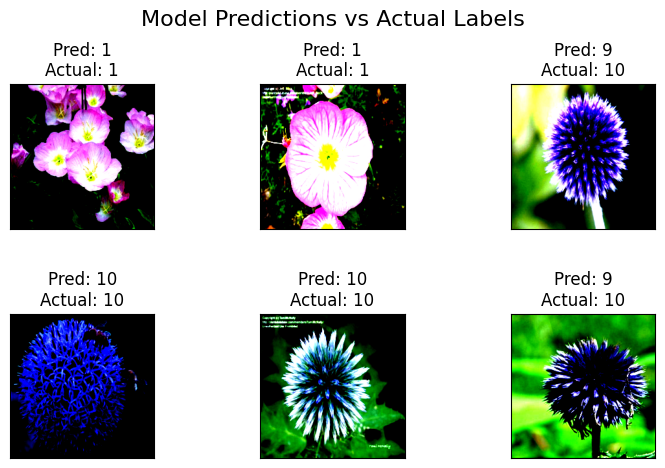

In [36]:
plt.figure(figsize=(8, 5))  # Larger figure for better visibility
f, axarr = plt.subplots(2, 3, figsize=( 8, 5))
counter = 4

for i in range(2):
    for j in range(3):
        # Display the image
        axarr[i][j].imshow(test_images[counter].squeeze().permute(1, 2, 0))

        # Get predicted and actual labels
        pred_label = classes[test_preds[counter]]
        actual_label = classes[test_labels[counter]]  # Assuming test_labels contains the true labels

        # Set title to show both predicted and actual labels
        axarr[i][j].set_title(f"Pred: {pred_label}\nActual: {actual_label}", fontsize=12)

        # Remove axis ticks for cleaner display
        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])

        counter += 1

plt.tight_layout(pad=3.0)  # Add padding between subplots
plt.suptitle("Model Predictions vs Actual Labels", fontsize=16, y=0.98)
plt.show()

In [37]:
#############################
# MODEL LOADING & INFERENCE #
#############################

In [38]:
# saving full model
torch.save(model, 'vision_transformer_flowers_full.pth')

In [39]:
def predict(image_path, model,classes):
    """
        Predict flower class from an image
    """

    try:
        transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Load and transform image
        img = Image.open(image_path).convert('RGB')
        image = transform(img).unsqueeze(0).to(config.device)

        # Print shape for debugging
        print(f"Transformed image shape: {image.shape}")

        with torch.no_grad():
            out = model(image)
            probabilities = F.softmax(out, dim=1)
            pred = torch.argmax(probabilities, dim=1)

        pred_class = classes[pred.item()]
        confidence = probabilities[0][pred.item()].item()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
        plt.title(f"Prediction: {pred_class}\nConfidence: {confidence:.4f}")
        plt.axis('off')

        # Plot probability distribution
        plt.subplot(1, 2, 2)
        sorted_indices = torch.argsort(probabilities[0], descending=True).cpu().numpy()
        top_classes = [classes[i] for i in sorted_indices[:5]]
        top_probs = [probabilities[0][i].item() for i in sorted_indices[:5]]

        plt.bar(range(len(top_classes)), top_probs)
        plt.xticks(range(len(top_classes)), top_classes, rotation=45)
        plt.title("Top 5 Class Probabilities")
        plt.tight_layout()
        plt.show()

        return pred_class, confidence

    except Exception as e:
        raise e

In [40]:
inference_model = torch.load('vision_transformer_flowers_full.pth', weights_only=False)
inference_model.eval()
inference_model.to(config.device)

VisionTransformer(
  (embedding): VisionEmbedding(
    (patch_embedding): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): VisionEncoder(
    (layers): ModuleList(
      (0-11): 12 x VisionEncoderLayer(
        (attn): VisionAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): VisionMLP(
          (layer1): Linear(in_features=768, out_features=2304, bias=True)
          (layer2): Linear(in_features=2304, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps

Transformed image shape: torch.Size([1, 3, 224, 224])


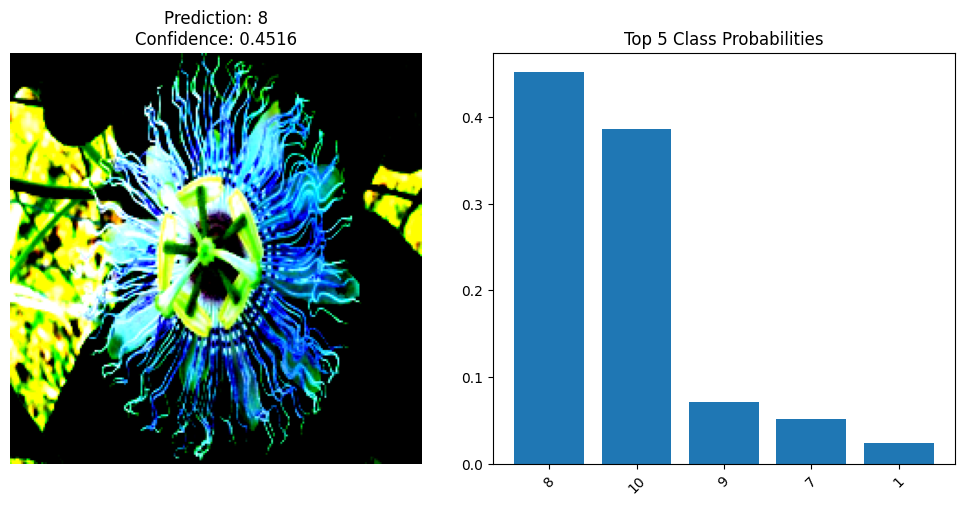

Predicted: 8 with 45.16% confidence


In [41]:
image_path = "/content/jpg/image_00025.jpg"
class_name, conf = predict(image_path, inference_model, classes)
print(f"Predicted: {class_name} with {conf*100:.2f}% confidence")